In [1]:
import pickle, os, time
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from nda import log
from nda.problems import *
from nda.optimizers import *
from nda.optimizers.utils import generate_mixing_matrix
from nda.experiment_utils import run_exp

from BEER import BEER

In [2]:
def get_bits_per_round_per_agent(config, dim):
    if 'compressor_type' in config:
        if config['compressor_type'] == 'random':
            return config['compressor_param'] * 64
        elif config['compressor_type'] == 'top':
            return config['compressor_param'] * 64
        elif config['compressor_type'] == 'gsgd':
            return config['compressor_param'] * dim
    return dim * 64

In [3]:
def plot_exp(results, name, logx=False, logy=False, figsize=None, dpi=None, save=False, plot_norm=False, plot_bits=True, legends=None):

    max_bits = min([_[1].bits.iloc[-1] for _ in results]) * 1.1
    max_iters = min([_[1].t.iloc[-1] for _ in results])

    if plot_bits:
        fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=dpi)
    else:
        fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

    line_styles = [color + style for style in ['-', '--', ':'] for color in ['k', 'r', 'g', 'b', 'c', 'm', 'y']]

    for i in range(len(results)):

        data = results[i][1]
        style = line_styles[i]

        def _plot(index, x, y, n, xlabel='', ylabel=''):
            ax = axs[index]
            mask = data[x].values <= n
            ax.plot(
                data[x].values[mask],
                data[y].values[mask],
                style
            )
            ax.set(xlabel=xlabel, ylabel=ylabel)
            if logy:
                ax.set_yscale('log')
            if logx:
                ax.set_xscale('log')

        if not plot_norm:
            _plot(0, 't', 'f', max_iters, xlabel='Iterations', ylabel='Training loss')
            if plot_bits:
                _plot(2, 'bits', 'f', max_bits, xlabel='Bits communicated', ylabel='Training loss')
        else:
            _plot(0, 't', 'grad_norm', max_iters, xlabel='Iterations', ylabel='Training gradient norm')
            if plot_bits:
                _plot(2, 'bits', 'grad_norm', max_bits, xlabel='Bits communicated', ylabel='Training gradient norm')

        _plot(1, 't', 'test_accuracy', max_iters, xlabel='Iterations', ylabel='Testing accuracy')
        if plot_bits:
            _plot(3, 'bits', 'test_accuracy', max_bits, xlabel='Bits communicated', ylabel='Testing accuracy')

    if legends is None:
        plt.legend([_[0] for _ in results])
    else:
        plt.legend(legends)

    return fig

In [4]:
def save_exp(results, configs, name, **kwargs):

    for res, config in zip(results, configs):
        data = res[1]
        data['t'] = data['t'].astype(int)
        data['n_grads'] = data['n_grads'].astype(int)
        data['bits'] = get_bits_per_round_per_agent(config, p.dim) * p.n_agent * data.comm_rounds

    kwargs['results'] = results
    with open(f"data/{name}.pkl", 'wb') as f:
        pickle.dump(kwargs, f)

# Nonconvex logistic regression on unshuffled a9a dataset

## Optimization algorithms

In [5]:
np.random.seed(0)

In [6]:
n_agent = 10

p = LogisticRegression(n_agent=n_agent, graph_type='cycle', alpha=0.05, dataset='a9a', sort=True)

m = p.m
dim = p.dim

x_0 = np.random.rand(dim, n_agent)
W, alpha = generate_mixing_matrix(p)

INFO 18:22:06.2699 44644 dataset.py:32] Loading a9a dataset from cached file
INFO 18:22:06.4262 44644 logistic_regression.py:63] Initializing using GPU
INFO 18:22:06.7171 44756 logistic_regression.py:86] Computing norm
INFO 18:22:07.4947 44644 logistic_regression.py:79] Initialization done


In [7]:
name = 'logistic_regression_nonconvex_a9a_unshuffled_algorithms'

In [8]:
n_iters = 2000
batch_size = 100
eta = 0.1

extra_metrics = ['test_accuracy', 'grad_norm']

BEER_configs = [
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd'},
]

CHOCO_SGD_configs = [
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd'},
]


for _ in CHOCO_SGD_configs + BEER_configs:
    _['extra_metrics'] = extra_metrics

baseline_exps = [
        DSGD(p, eta=eta, n_iters=n_iters, batch_size=batch_size, x_0=x_0, W=W, extra_metrics=extra_metrics),
        D2(p, eta=eta, n_iters=n_iters, batch_size=batch_size, x_0=x_0, W=W, extra_metrics=extra_metrics),
    ]

configs = BEER_configs + CHOCO_SGD_configs + len(baseline_exps) * [{}]
exps = [BEER(p, n_iters=n_iters, batch_size=batch_size, x_0=x_0, W=W, **config) for config in BEER_configs] \
        + [CHOCO_SGD(p, n_iters=int(n_iters * 2), batch_size=batch_size, x_0=x_0, W=W, **config) for config in CHOCO_SGD_configs] \
        + baseline_exps

begin = time.time()
res = run_exp(exps, max_iter=n_iters, name=name, n_gpus=4, plot=False)
end = time.time()
log.info('Total %.2fs', end - begin)


results = save_exp(res, configs, name, p=p, x_0=x_0, W=W)

INFO 18:22:07.5456 44644 BEER.py:21] gamma = 0.700
INFO 18:22:07.5553 44763 utils.py:21] BEER started
INFO 18:22:07.5621 44766 utils.py:21] CHOCO_SGD started
INFO 18:22:07.5676 44769 utils.py:21] DSGD started
INFO 18:22:07.5730 44772 utils.py:21] D2 started
INFO 18:22:17.7082 44769 utils.py:40] DSGD done, total 10.14s
INFO 18:22:17.7222 44772 utils.py:40] D2 done, total 10.15s
INFO 18:22:20.4751 44763 utils.py:40] BEER done, total 12.92s
INFO 18:22:26.5284 44766 utils.py:40] CHOCO_SGD done, total 18.97s
INFO 18:22:26.9177 44644 2744532748.py:32] Total 19.37s


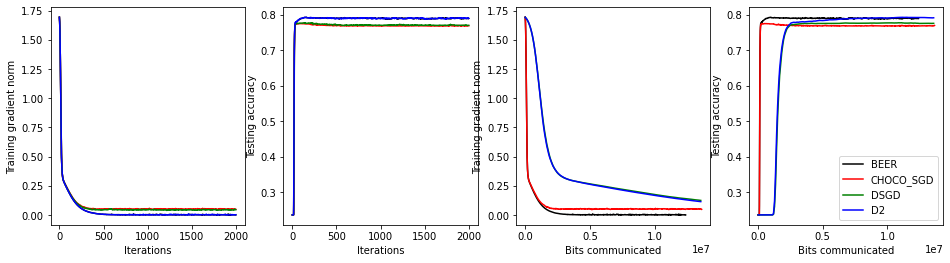

In [9]:
_ = plot_exp(res, name, plot_norm=True, figsize=(16, 4))

## Network topologies

In [10]:
np.random.seed(0)

In [11]:
n_agent = 40

p = LogisticRegression(n_agent=n_agent, graph_type='cycle', alpha=0.05, dataset='a9a', sort=True)

m = p.m
dim = p.dim

x_0 = np.random.rand(dim, n_agent)

log.info(f'n_agent = {n_agent}, m = {m}, dim = {dim}')

INFO 18:22:27.4819 44644 dataset.py:32] Loading a9a dataset from cached file
INFO 18:22:27.6301 44644 logistic_regression.py:63] Initializing using GPU
INFO 18:22:27.9261 44842 logistic_regression.py:86] Computing norm
INFO 18:22:28.7001 44644 logistic_regression.py:79] Initialization done
INFO 18:22:28.7017 44644 1823192667.py:10] n_agent = 40, m = 814, dim = 124


In [12]:
name = 'logistic_regression_nonconvex_a9a_unshuffled_BEER_topologies'

In [13]:
p.generate_graph('cycle')
W_ring, alpha_ring = generate_mixing_matrix(p)
log.info(f'Ring graph alpha = {alpha_ring}')

p.generate_graph('star')
W_star, alpha_star = generate_mixing_matrix(p)
log.info(f'Star graph alpha = {alpha_star}')

p.generate_graph('grid', (8, 5))
W_grid, alpha_grid = generate_mixing_matrix(p)
log.info(f'Grid graph alpha = {alpha_grid}')

p.generate_graph('er', 0.2)
W_er_1, alpha_er_1 = generate_mixing_matrix(p)
log.info(f'E-R graph alpha 1 = {alpha_er_1}')

p.generate_graph('er', 0.5)
W_er_2, alpha_er_2 = generate_mixing_matrix(p)
log.info(f'E-R graph alpha 2 = {alpha_er_2}')

INFO 18:22:29.1047 44644 428404896.py:3] Ring graph alpha = 0.9877636702191784
INFO 18:22:29.1761 44644 428404896.py:7] Star graph alpha = 0.9512196929360809
INFO 18:22:29.8321 44644 428404896.py:11] Grid graph alpha = 0.937435395007552
INFO 18:22:30.2103 44644 428404896.py:15] E-R graph alpha 1 = 0.575556482227369
INFO 18:22:30.8622 44644 428404896.py:19] E-R graph alpha 2 = 0.2307982930907105


In [14]:
n_iters = 2000
batch_size = 100
eta = 0.1 * 5

extra_metrics = ['test_accuracy', 'grad_norm']

configs = [
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd', 'W': W_ring},
    
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd', 'W': W_star},
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd', 'W': W_grid},

        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd', 'W': W_er_1},
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd', 'W': W_er_2},
]

exps = [BEER(p, n_iters=n_iters, batch_size=batch_size, x_0=x_0, early_stopping=False, extra_metrics=extra_metrics, **config) for config in configs]

begin = time.time()

res = run_exp(exps, max_iter=n_iters, name=name, n_gpus=4, plot=False)
end = time.time()
log.info('Total %.2fs', end - begin)

save_exp(res, configs, name, p=p, x_0=x_0, W_er_1=W_er_1, W_er_2=W_er_2)

INFO 18:22:30.8715 44644 BEER.py:21] gamma = 0.700
INFO 18:22:30.8721 44644 BEER.py:21] gamma = 0.700
INFO 18:22:30.8724 44644 BEER.py:21] gamma = 0.700
INFO 18:22:30.8728 44644 BEER.py:21] gamma = 0.700
INFO 18:22:30.8732 44644 BEER.py:21] gamma = 0.700
INFO 18:22:30.8860 44851 utils.py:21] BEER started
INFO 18:22:30.8953 44854 utils.py:21] BEER started
INFO 18:22:30.9036 44857 utils.py:21] BEER started
INFO 18:22:30.9116 44860 utils.py:21] BEER started
INFO 18:22:54.0380 44854 utils.py:40] BEER done, total 23.14s
INFO 18:22:54.2699 44902 utils.py:21] BEER started
INFO 18:22:54.3743 44851 utils.py:40] BEER done, total 23.49s
INFO 18:22:54.8524 44860 utils.py:40] BEER done, total 23.94s
INFO 18:22:58.6208 44857 utils.py:40] BEER done, total 27.72s
INFO 18:23:17.3975 44902 utils.py:40] BEER done, total 23.13s
INFO 18:23:17.7143 44644 406167172.py:23] Total 46.84s


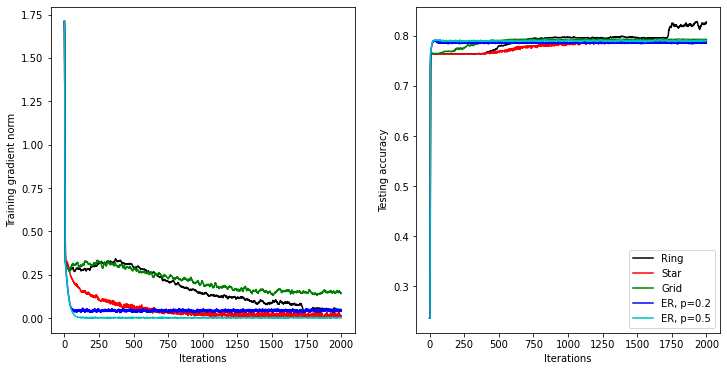

In [15]:
_ = plot_exp(res, name, plot_norm=True, figsize=(12, 6), plot_bits=False, legends=['Ring', 'Star', 'Grid', 'ER, p=0.2', 'ER, p=0.5'])

## Compressors

In [16]:
np.random.seed(0)

In [17]:
n_agent = 40

p = LogisticRegression(n_agent=n_agent, graph_type='cycle', alpha=0.05, dataset='a9a', sort=True)
W, alpha = generate_mixing_matrix(p)

m = p.m
dim = p.dim

x_0 = np.random.rand(dim, n_agent) / 10

log.info(f'n_agent = {n_agent}, m = {m}, dim = {dim}')

INFO 18:23:18.0517 44644 dataset.py:32] Loading a9a dataset from cached file
INFO 18:23:18.1766 44644 logistic_regression.py:63] Initializing using GPU
INFO 18:23:18.4749 44997 logistic_regression.py:86] Computing norm
INFO 18:23:19.2373 44644 logistic_regression.py:79] Initialization done
INFO 18:23:19.5995 44644 3579017516.py:11] n_agent = 40, m = 814, dim = 124


In [18]:
name = 'logistic_regression_nonconvex_a9a_unshuffled_BEER_compressors'

In [19]:
n_iters = 2000
batch_size = 100
eta = 0.1 * 5

extra_metrics = ['test_accuracy', 'grad_norm']

configs = [
        {'eta': eta, 'gamma': 7e-1, 'W': W},
        {'eta': eta, 'compressor_param': 5, 'gamma': 7e-1, 'compressor_type': 'gsgd', 'W': W},
        {'eta': eta / 100, 'compressor_param': 10, 'gamma': 8e-1, 'compressor_type': 'top', 'W': W},
]


exps = [BEER(p, n_iters=n_iters, batch_size=batch_size, x_0=x_0, early_stopping=False, extra_metrics=extra_metrics, **config) for config in configs]

begin = time.time()
res = run_exp(exps, max_iter=n_iters, name=name, n_gpus=4, plot=False, save=True)
end = time.time()

log.info('Total %.2fs', end - begin)

save_exp(res, configs, name, p=p, x_0=x_0, W=W)

INFO 18:23:19.6334 44644 BEER.py:21] gamma = 0.700
INFO 18:23:19.6339 44644 BEER.py:21] gamma = 0.700
INFO 18:23:19.6343 44644 BEER.py:21] gamma = 0.800
INFO 18:23:19.6474 45004 utils.py:21] BEER started
INFO 18:23:19.6580 45007 utils.py:21] BEER started
INFO 18:23:19.6679 45010 utils.py:21] BEER started
INFO 18:23:42.7804 45007 utils.py:40] BEER done, total 23.12s
INFO 18:23:43.4376 45004 utils.py:40] BEER done, total 23.79s
INFO 18:23:44.0109 45010 utils.py:40] BEER done, total 24.34s
INFO 18:23:44.3958 44644 2078504275.py:20] Total 24.76s


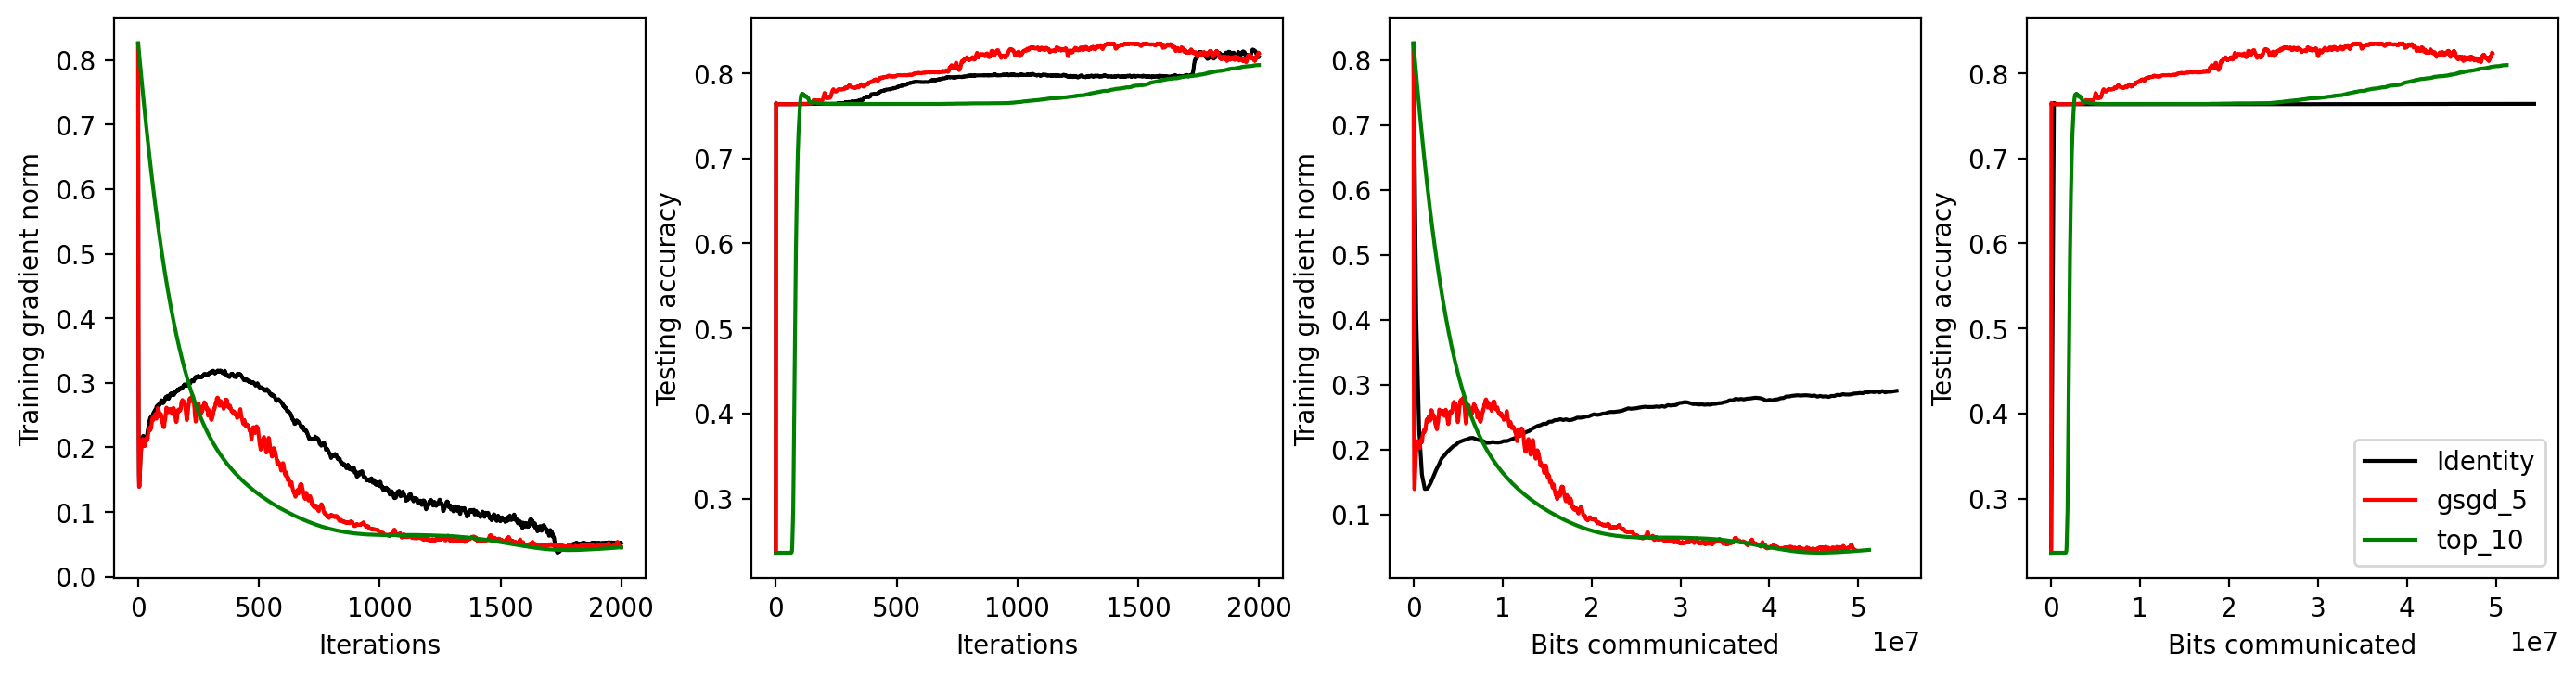

In [20]:
_ = plot_exp(res, name, plot_norm=True, figsize=(17, 4), dpi=200, legends=['Identity', 'gsgd_5', 'top_10'])

# 1-hidden-layer NN on MNIST

In [21]:
np.random.seed(0)

In [22]:
experiment = 'nn'

n_agent = 10

p = NN(n_agent=n_agent, graph_type='cycle', n_hidden=32, sort=True)
m = p.m
dim = p.dim

x_0 = np.random.randn(dim, n_agent) / 10

W, alpha = generate_mixing_matrix(p)

log.info('alpha = ' + str(alpha))
x_0_mean = x_0.mean(axis=1)

INFO 18:23:44.9267 44644 dataset.py:32] Loading MNIST dataset from cached file
INFO 18:23:46.7370 44644 neural_network.py:48] Initialization done
INFO 18:23:46.7670 44644 1521433505.py:13] alpha = 0.8256645580054005


In [23]:
name = 'mnist_unshuffled_BEER_CHOCO_SGD_32_hidden'

In [24]:
n_iters = 2000
batch_size = 100
eta = 0.1

extra_metrics = ['test_accuracy', 'grad_norm']

BEER_configs = [
        {'eta': eta, 'compressor_param': 20, 'gamma': 6e-1, 'compressor_type': 'gsgd', 'extra_metrics': extra_metrics},
]

CHOCO_SGD_configs = [
        {'eta': eta, 'compressor_param': 20, 'gamma': 6e-1, 'compressor_type': 'gsgd', 'extra_metrics': extra_metrics},
]

for _ in CHOCO_SGD_configs + BEER_configs:
    _['extra_metrics'] = extra_metrics

baseline_exps = [
        DSGD(p, eta=eta, n_iters=n_iters, batch_size=batch_size, x_0=x_0, W=W, early_stopping=False, extra_metrics=extra_metrics),
        D2(p, eta=eta, n_iters=n_iters, batch_size=batch_size, x_0=x_0, W=W, early_stopping=False, extra_metrics=extra_metrics),
    ]


configs = BEER_configs + CHOCO_SGD_configs + len(baseline_exps) * [{}]
exps = [BEER(p, n_iters=n_iters, batch_size=batch_size, x_0=x_0, W=W, early_stopping=False, **config) for config in BEER_configs] \
        + [CHOCO_SGD(p, n_iters=int(n_iters * 2), batch_size=batch_size, x_0=x_0, W=W, early_stopping=False, **config) for config in CHOCO_SGD_configs] \
        + baseline_exps


begin = time.time()
res = run_exp(exps, max_iter=n_iters, name=name, n_gpus=4, plot=False, save=True)
end = time.time()
log.info('Total %.2fs', end - begin)

save_exp(res, configs, name, p=p, x_0=x_0, W=W)

INFO 18:23:46.8136 44644 BEER.py:21] gamma = 0.600
INFO 18:23:46.8423 45546 utils.py:21] BEER started
INFO 18:23:46.8612 45549 utils.py:21] CHOCO_SGD started
INFO 18:23:46.8796 45552 utils.py:21] DSGD started
INFO 18:23:46.8965 45556 utils.py:21] D2 started
INFO 18:26:43.5584 45552 utils.py:40] DSGD done, total 176.68s
INFO 18:26:47.6918 45546 utils.py:40] BEER done, total 180.85s
INFO 18:26:50.0062 45556 utils.py:40] D2 done, total 183.11s
INFO 18:29:42.5120 45549 utils.py:40] CHOCO_SGD done, total 355.65s
INFO 18:29:43.2642 44644 1301498776.py:33] Total 356.44s


In [25]:
res[1][1] = res[1][1].iloc[::4]

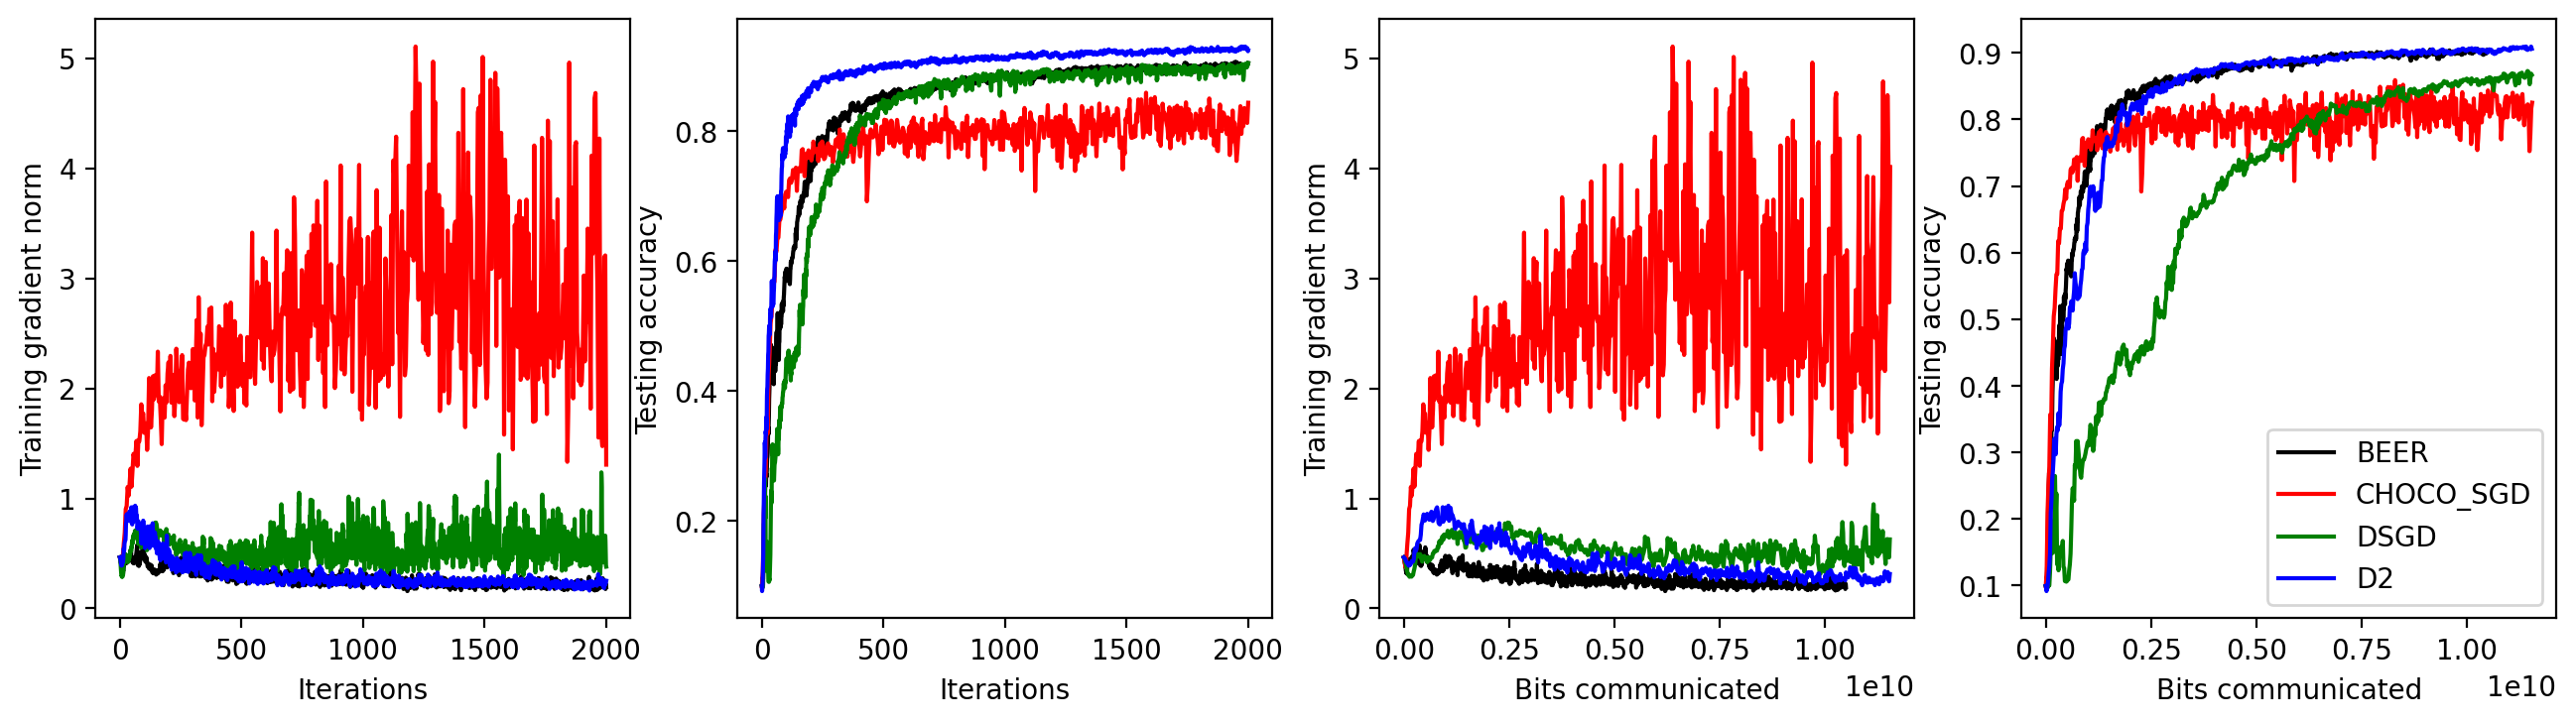

In [26]:
_ = plot_exp(res, name, plot_norm=True, figsize=(16, 4), dpi=200)

# Convolutional neural network on MNIST

In [27]:
import pandas as pd

In [28]:
def plot_final_bits(exps):
    figs, axs = plt.subplots(1, 2, figsize=(10, 5))
    legends = []

    max_bits = 1e100
    for exp in exps:
        try:
            fname = [_ for _ in os.listdir(exp) if 'full' in _ and 'train' in _][0][:-10]
            df_val = pd.read_csv(f'{exp}/{fname}_val.txt', sep=' ')
            x = df_val.iterations * 29034 * 5
            if 'BEER' in fname:
                x *= 2
            max_bits = min(x.iloc[-1], max_bits)
        except:
            print(f'Failed to plot {exp}')

    for exp in exps:
        try:
            fname = [_ for _ in os.listdir(exp) if 'full' in _ and 'train' in _][0][:-10]
            df_train = pd.read_csv(f'{exp}/{fname}_train.txt', sep=' ')
            df_val = pd.read_csv(f'{exp}/{fname}_val.txt', sep=' ')
            x = df_val.iterations * 29034 * 5
            if 'BEER' in fname:
                x *= 2
            mask = x <= max_bits

            axs[0].plot(x.loc[mask], (df_val.loc[mask].grad_norm ** 2).expanding().mean())
            axs[1].plot(x.loc[mask], df_val.loc[mask].accuracy)
            legends.append(exp.split('/')[-1])
            print(exp)
        except:
            print(f'Failed to plot {exp}')

    axs[0].set_ylabel('Testing gradient norm')
    axs[0].set_xlabel('Communication bits')

    axs[1].set_ylabel('Testing accuracy')
    axs[1].set_xlabel('Communication bits')

    axs[1].legend(legends)

    plt.show()

mnist/experiments/BEER_10_agents_er_graph_lr_0.000100_gamma_0.01000_gsgd_5_cuda
mnist/experiments/CHOCO_SGD_10_agents_er_graph_lr_0.000100_gamma_0.01000_gsgd_5_cuda


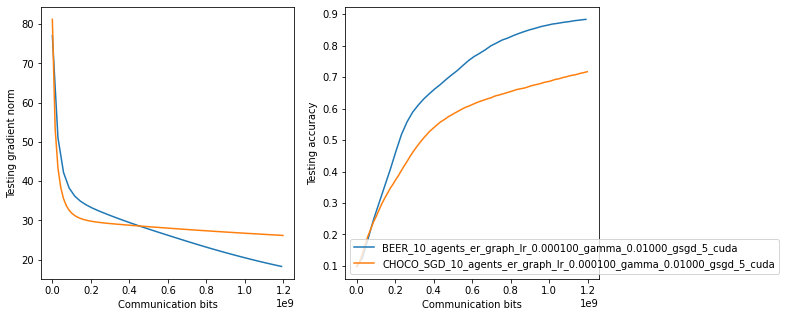

In [29]:
exps = sorted(os.listdir('mnist/experiments'))
plot_final_bits([os.path.join('mnist/experiments', _) for _ in exps])